# Setup

In [31]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
path = os.path.abspath('')
path = path + "/engineered_data_250ms_window80_step8.csv"
df = pd.read_csv(path)

print("Shape of DataFrame:", df.shape, "and number of features after deleting base columns:", len(df.drop(["Window", "Participant", "Run", "Path"], axis=1).columns))

Shape of DataFrame: (1306, 226) and number of features after deleting base columns: 222


# Preprocessing data 
The goal here is to ensure that the originally engineered data set is used with the 226 columns that we developed. I wanted to create a dataset that can be easily truncated later on. In order to do that I look at the whole dataset first. I will check for shape and ensure all are numerical values. A test and training set are created. Afterwards I have been trying out a little bit of robustscaler to ensure all the data is normalized properly before feeding it to an LSTM, which benefits from quicker convergence if data is normalized already. 

In [82]:
#cleaning the data set further
# Replace string values with numerical values for easier processing in models
df['Participant'] = df['Participant'].replace({'Dany': 0, 'Felix': 1, 'Julian': 2, 'Mark': 3, 'Martin': 4, 'Michele': 5, 'Paul': 6}) # for participants column
df['Path'] = df['Path'].replace({'straight': 0, 'circle': 1}) #for path column

#create train/test set
#should maybe do random runs in the future
X_Train = df[df['Run'] < 4].copy()
X_Test = df[df['Run'] == 4].copy()

# Extracting targets
Y_Train = X_Train.pop('Participant')
Y_Test = X_Test.pop('Participant')

# Verifying the final shapes and content of datasets
print("X_Train shape:", X_Train.shape)
print("X_Test shape:", X_Test.shape)
print("Y_Train shape:", Y_Train.shape)
print("Y_Test shape:", Y_Test.shape)

#Display a few rows to confirm correct data setup
print(X_Train['Path'].sample(3))
print(X_Test['Path'].sample(3))

# In order to solve the NaN issue, i try to locate the values
print("NaN in X_Train:", X_Train.isnull().sum().sum())
print("NaN in Y_Train:", Y_Train.isnull().sum().sum())
print("NaN in X_Test:", X_Test.isnull().sum().sum())

# If you'd like to see an example of where the NaN is located, uncomment below. 
# # Find rows with NaN values in X_Train
# nan_rows_X_Train = X_Train[X_Train.isnull().any(axis=1)]
# print("Rows with NaN values in X_Train:")
# print(nan_rows_X_Train)


# # Find rows with NaN values in X_Test
# nan_rows_X_Test = X_Test[X_Test.isnull().any(axis=1)]
# print("Rows with NaN values in X_Test:")
# print(nan_rows_X_Test)

# Print the number of unique rows that have NaN in X_Train and X_Test
print("Number of unique rows with NaN in X_Train:", nan_rows_X_Train.shape[0])
print("Number of unique rows with NaN in X_Test:", nan_rows_X_Test.shape[0])

# In order to solve the NaN issue in the SVM I will drop the the NaN values
# Remove rows with NaN values from X_Train and X_Test
X_Train_cleaned = X_Train.dropna()
X_Test_cleaned = X_Test.dropna()

# Ensure the target variables are aligned
Y_Train_cleaned = Y_Train[X_Train_cleaned.index]
Y_Test_cleaned = Y_Test[X_Test_cleaned.index]

# Ensure Y_Train_cleaned and Y_Test_cleaned is of integer type
Y_Train_cleaned = Y_Train_cleaned.astype(int)
Y_Test_cleaned = Y_Test_cleaned.astype(int)

X_Train shape: (1019, 225)
X_Test shape: (287, 225)
Y_Train shape: (1019,)
Y_Test shape: (287,)
556    0
742    0
79     1
Name: Path, dtype: int64
926    0
757    0
762    0
Name: Path, dtype: int64
NaN in X_Train: 55489
NaN in Y_Train: 0
NaN in X_Test: 14301
Number of unique rows with NaN in X_Train: 1019
Number of unique rows with NaN in X_Test: 287


# Normalizing
I have not completed this step, could you please pick this up and ensure the data is normalized?
Data of the first four columns are not to be normalized and need to remain the same, the rest of the data is sensor data and should be normalized I haven't figured it out yet. 

In [ ]:
# # Define a ColumnTransformer that will apply RobustScaler to all columns except the first four
# # The first four columns are passed through without scaling using 'passthrough'
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', RobustScaler(), df.columns[4:]),  # Apply RobustScaler to columns from the 5th to the last
#         ('pass', 'passthrough', df.columns[:4])   # Pass through the first four columns without scaling
#     ],
#     remainder='drop'  # Drop columns not specified explicitly (none in this case)
# )
# 
# # Fit and transform the data using ColumnTransformer
# df_scaled = pd.DataFrame(preprocessor.fit_transform(df), columns=df.columns)
# 
# # Print or analyze the transformed DataFrame
# print(df_scaled.head())

## Locating NaN values and ensuring proper deletion
Here I have attempted to get a good understtanding of where the NaN data is located in our dataset. 
Afterwards I will do a detailed analysis of the columns and rows specifically. I go through some cycles and different approaches in deleting the NaN values. I started with deleting the columns with a 100% NaN but later made a graph that shows the cutoff point in the data I will actually use. If you run the code and just read the comments and graphs you should be able to understand the gist of it. 

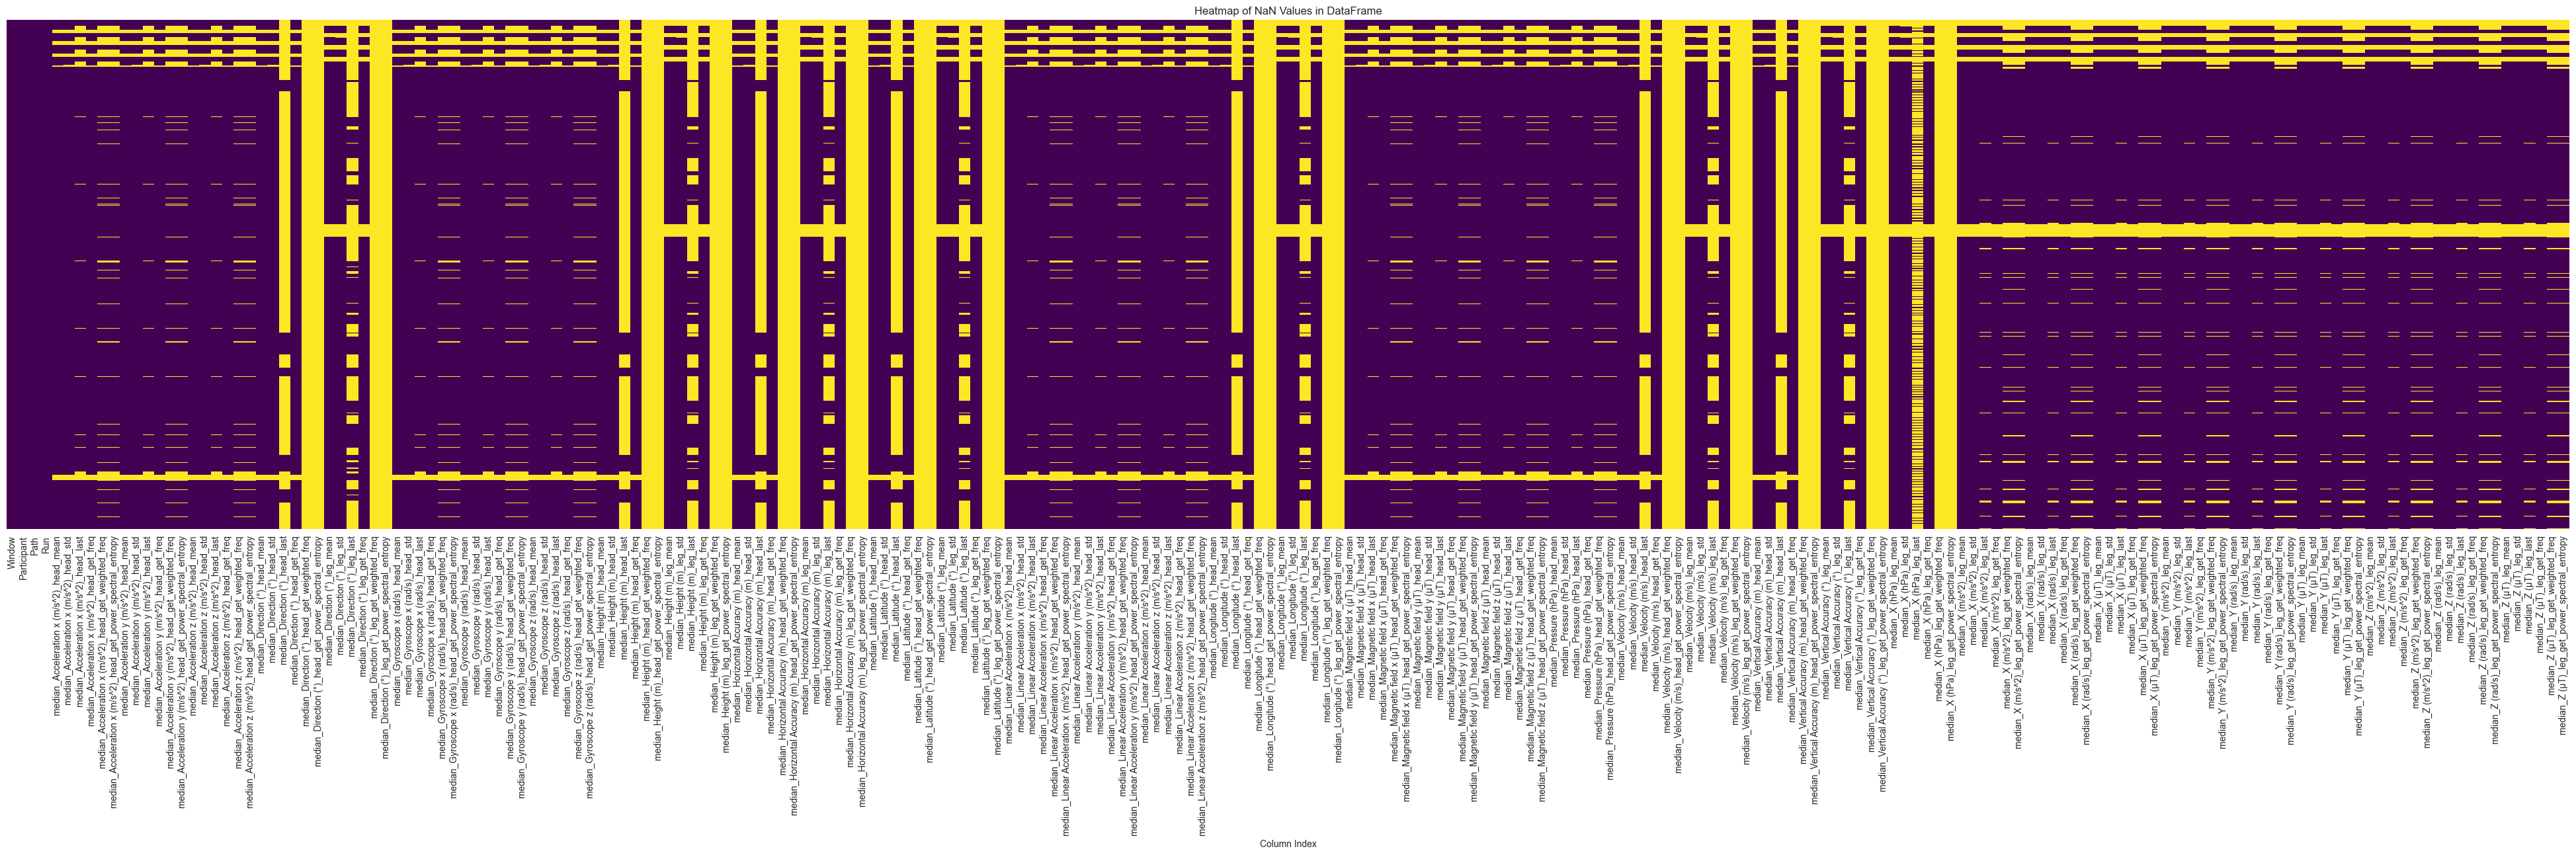

In [37]:
# Create a binary DataFrame showing where NaNs are located
nan_map = df.isnull()

# Create a heatmap
plt.figure(figsize=(50, 10))  # Adjust size as needed to display all columns
sns.heatmap(nan_map, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of NaN Values in DataFrame')
plt.xlabel('Column Index')
plt.show()

In [72]:
# Check how many columns have 100 percent NaN
columns_to_drop = df.columns[df.isnull().mean() == 1]
print("Numbers of columns that have 100% NaN:", len(columns_to_drop))
#drop NaN columns
df_cleaned = df.drop(columns=df.columns[df.isnull().mean() == 1])

Numbers of columns that have 100% NaN: 30


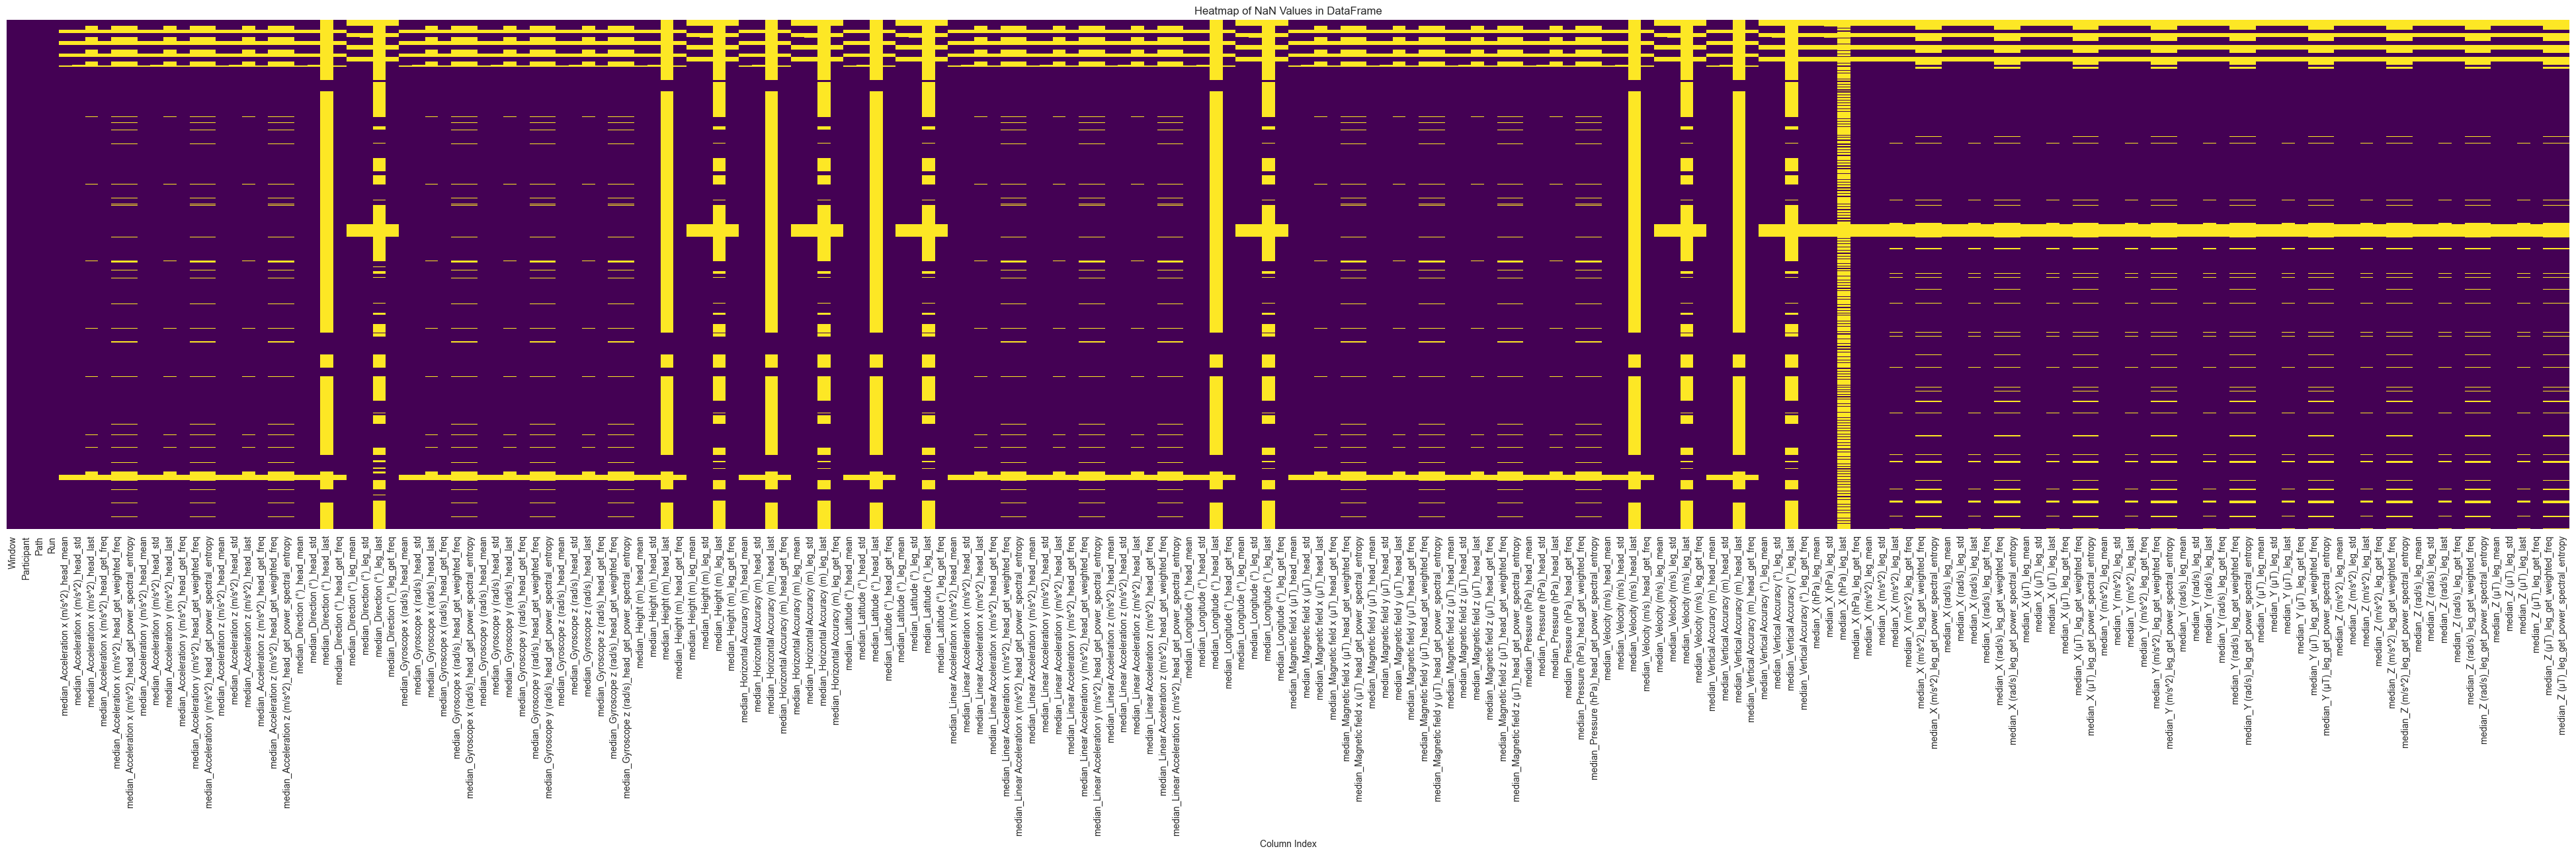

In [73]:
# create an updated map of the NaN
nan_map = df_cleaned.isnull()

# Create a heatmap
plt.figure(figsize=(50, 10))  # Adjust size as needed to display all columns
sns.heatmap(nan_map, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of NaN Values in DataFrame')
plt.xlabel('Column Index')
plt.show()

### This area is used to more formally find a good cutoff point for the NaN values. 
The columns that have more than 20% NaN values can be deleted without losing all too many features. The rest of the missing data should be imputed. Probably it is best to use interpolation for that. 

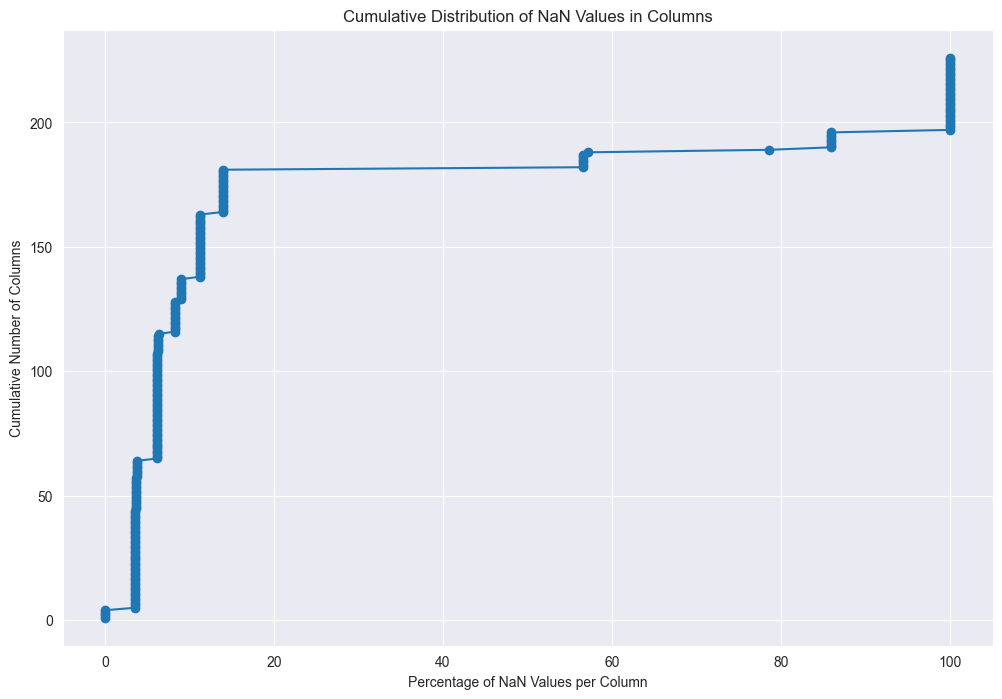

In [74]:
# Calculate the percentage of NaN values for each column
perc_NaN_per_column = df.isnull().mean() * 100

# Sort the percentages
sorted_perc = np.sort(perc_NaN_per_column)

# Calculate the cumulative count of columns
cumulative_counts = np.arange(1, len(sorted_perc) + 1)

# Plot the cumulative distribution
plt.figure(figsize=(12, 8))
plt.plot(sorted_perc, cumulative_counts, marker='o', linestyle='-')
plt.xlabel('Percentage of NaN Values per Column')
plt.ylabel('Cumulative Number of Columns')
plt.title('Cumulative Distribution of NaN Values in Columns')
plt.grid(True)
plt.show()

### Row NaN deletion
It is probably a good idea to delete the rows that have more than 50 or 55% of NaN and impute the rest using interpolation. The reason I give this amount is because deleting at the 22% mark would result in about 15-20% loss of data, which I find a bit too much for the rows. Especially if we will impute some missing data I think it makes sense to not delete all too many rows. 

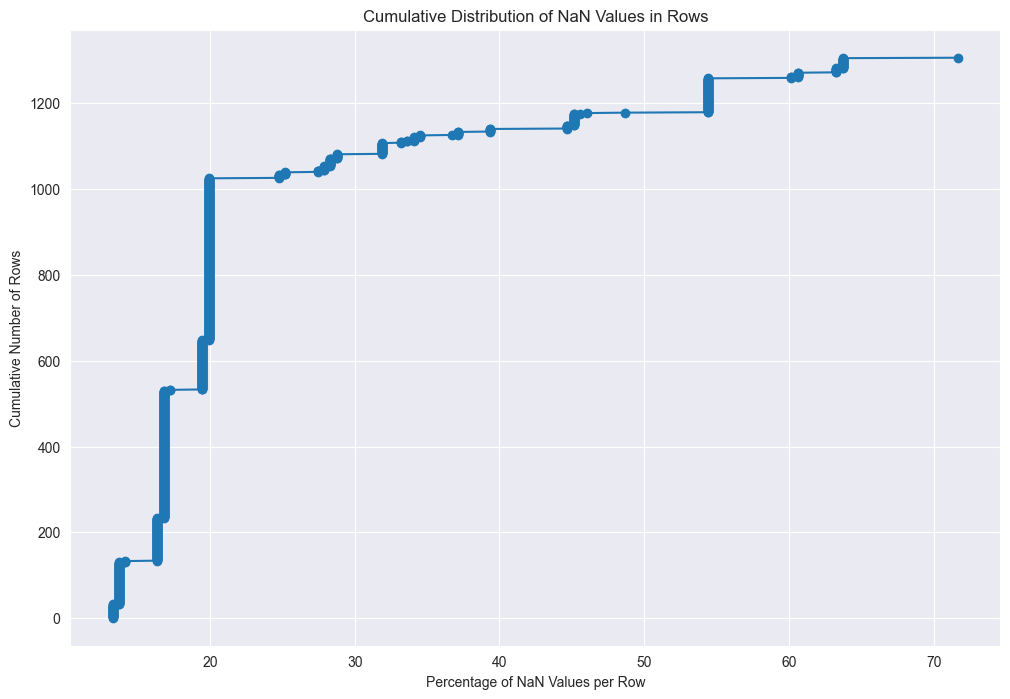

In [75]:
# Calculate the percentage of NaN values for each row
perc_NaN_per_row = df.isnull().mean(axis=1) * 100

# Sort the percentages
sorted_perc = np.sort(perc_NaN_per_row)

# Calculate the cumulative count of rows
cumulative_counts = np.arange(1, len(sorted_perc) + 1)

# Plot the cumulative distribution
plt.figure(figsize=(12, 8))
plt.plot(sorted_perc, cumulative_counts, marker='o', linestyle='-')
plt.xlabel('Percentage of NaN Values per Row')
plt.ylabel('Cumulative Number of Rows')
plt.title('Cumulative Distribution of NaN Values in Rows')
plt.grid(True)
plt.show()

# Next steps - TODO 
So far the data has been preprocessed for 50%. 
There needs to be some more adjustments to it. 
These are:

- Normalizing (I haven't tested this out yet)
- Deleting the columns that have more than 20% NaN values
- Deleting the rows that have more than 50 or 55% of NaN values
- Imputing the missing data using interpolation (or another suitable temporally coherent method)
- Setting up the LSTM data pipeline and feed data
- Interpret results of the model